In [1]:
import numpy as np
import pandas as pd
import pygimli as pg
from pygimli.physics import ert
import matplotlib.pyplot as plt
import math


## load data file (already in BERT unified data format)

In [2]:
# data_raw = ert.load('data_unified/CER2017-08-24_u_i.txt') 
# data_raw = ert.load('data_unified/craterlake_2019_feb6.txt') # crater lake, good data quality
# data_raw = ert.load('data_unified/craterlake_2019_may3.txt') # crater lake, has bad electrode
# data_raw = ert.load('data_unified/oldcrow_wen13_2013_oct14.txt') # old crow, line 13
# data_raw = ert.load('data_unified/oldcrow_wen1_2013_oct13.txt') # old crow, line 1
data_raw = ert.load('data_unified/SCH2018-08-29_u_i.txt') # schilthorn
# data_raw = ert.load('data_unified/2001_ALK_2019-10-03_0600_fr.ohm') # seward peninsula summer, forward and reciprocal data
# data_raw = ert.load('data_unified/2001_ALK_2020-02-01_1000_fr.ohm') # seward peninsula winter, forward and reciprocal data
# data_raw = ert.load('data_unified/beavercreek_wen1_2010_july22.txt') 
# data_raw = ert.load('data_unified/mp825_2021_sept8_fr.txt')

print(data_raw)

Data: Sensors: 50 data: 376, nonzero entries: ['a', 'b', 'err', 'i', 'm', 'n', 'u', 'valid']


/opt/anaconda3/conda-bld/pgcore_1645178403028/work/gimli/core/src/bert/bertDataContainer.cpp:107		virtual void GIMLI::DataContainerERT::checkDataValidityLocal()  In datafile zero current or voltage found.


## check the data
* calculate geometric factor and apparent resistivity if not already in data file
* look for reciprocal or repeated measurements. if present, calculate new apparent resistivities and error values

In [3]:
# calculate geometric factor and apparent resistivity if not already in data file

if data_raw.haveData('k')==False:
    data_raw['k'] = ert.createGeometricFactors(data_raw,numerical=True) # include topo in k calculation
    
if data_raw.haveData('rhoa')==False:
    if data_raw.haveData('r')==False:
        data_raw['r'] = data_raw['u']/data_raw['i']
    data_raw['rhoa'] = data_raw['r']*data_raw['k'] 


# put data into pandas dataframe

df = pd.DataFrame(np.array(data_raw.dataMap(),dtype='object').T)
header = df.iloc[0]
df = df[1:] 
df.columns = header
df = df.apply(pd.Series.explode).reset_index(drop=True)

df_raw = pd.DataFrame(df)
df_raw['start_index'] = df_raw.index

# look for reciprocal or repeated measurements

src = np.stack([df_raw['a'],df_raw['b']]).T
rec = np.stack([df_raw['m'],df_raw['n']]).T

src_f = src[0]
rec_f = rec[0]
ind_f = [0]
ind_r = []
reps = []
recips = []

for i in range(1,len(src)): 

    if len(rec_f)==2:
        a = np.where(np.all(rec_f==src[i],axis=0))[0] # reciprocals
        b = np.where(np.all(src_f==rec[i],axis=0))[0]
        
        c = np.where(np.all(src_f==src[i],axis=0))[0] # repeated
        d = np.where(np.all(rec_f==rec[i],axis=0))[0]
    else:
        a = np.where(np.all(rec_f==src[i],axis=1))[0] # reciprocals
        b = np.where(np.all(src_f==rec[i],axis=1))[0]
        
        c = np.where(np.all(src_f==src[i],axis=1))[0] # repeated
        d = np.where(np.all(rec_f==rec[i],axis=1))[0]   
        
    ind_recip = np.intersect1d(a,b)
    ind_rep = np.intersect1d(c,d)
        
    if len(ind_recip)>0:
        ind_r.append(i)
        recips.append(ind_recip)
            
    elif len(ind_rep)>0:
        ind_r.append(i)
        reps.append(ind_rep)
        
    else:
        src_f = np.vstack((src_f,[src[i]]))
        rec_f = np.vstack((rec_f,[rec[i]]))
        ind_f.append(i)
        
recips = np.squeeze(recips) 
reps = np.squeeze(reps)

print('%.0f reciprocal measurements detected'%len(recips))     
print('%.0f repeated measurements detected'%len(reps))

# treat repeated and reciprocal measurements the same
r_all = np.hstack([reps,recips]).astype(int)

# if present, calculate new apparent resistivities and error vals

df_f = df_raw.loc[ind_f]
df_f = df_f.reset_index(drop=True)

df_r = df_raw.loc[ind_r]
df_r = df_r.reset_index(drop=True)

df_checked = df_f.copy()
df_checked['rep/recip'] = 0

if len(ind_r)>0: #TODO this only handles recips now

    for i in range(len(ind_r)): # for all reciprocal measurements

        r_mean = (df_f.iloc[r_all[i]]['r'] + df_r.iloc[i]['r'])/2 
        r_err = (np.abs(df_f.iloc[r_all[i]]['r'] - df_r.iloc[i]['r'])/abs(r_mean))*100    
        df_checked.at[r_all[i],'r'] = r_mean
        df_checked.at[r_all[i],'rhoa'] = r_mean*df_r.iloc[i]['k']
        df_checked.at[r_all[i],'err'] = r_err
        df_checked.at[r_all[i],'rep/recip'] = 1

27/06/22 - 14:41:25 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (4.9s x 32): /Users/teddiherringnew/Library/Caches/pygimli/9009290000904741989


0 reciprocal measurements detected
0 repeated measurements detected


## plot the observed data 

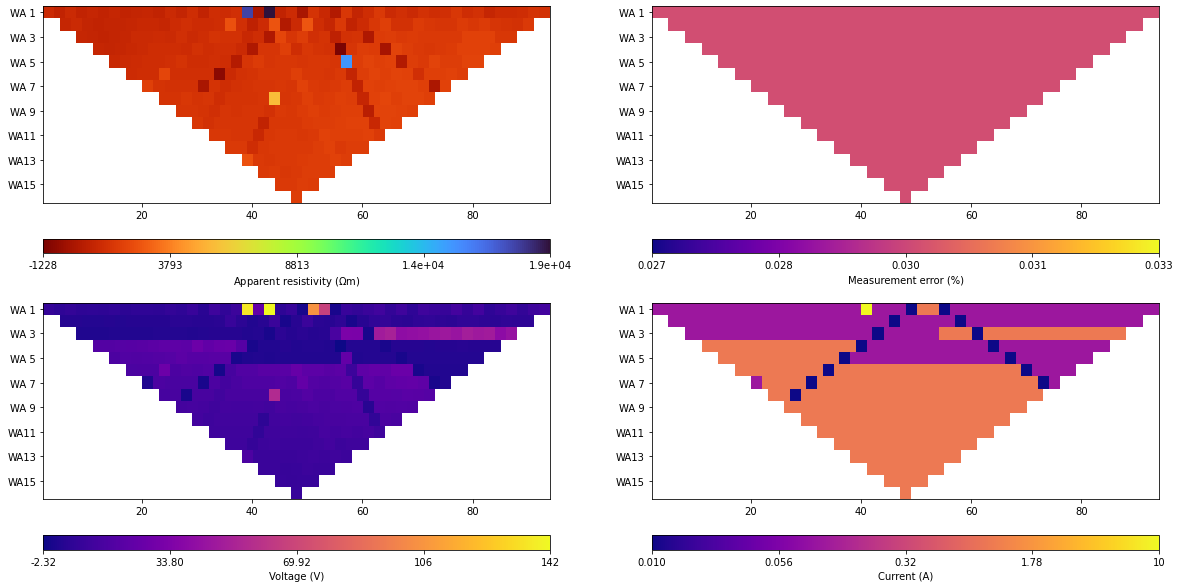

In [4]:
# put everything back into the pygimli data container to plot
data_checked = pg.DataContainerERT()

# sensors are the same
for i in range(0,len(data_raw.sensors())):
    data_checked.createSensor(np.array(data_raw.sensors()[i])) # 2D, no topography

# add filtered quadripoles and data 

cols = df_checked.columns
for i in range(len(cols)):
    if max(df_checked[cols[i]]) > 0:
        data_checked[cols[i]] = np.array(df_checked[cols[i]])


mgr = ert.ERTManager(data_checked)

fig, ax = plt.subplots(2,2,figsize=[20,10])

mgr.showData(data_checked, vals=data_checked['rhoa'],ax=ax[0,0],label=r'Apparent resistivity ($\Omega$m)',cMap='turbo_r');

if data_checked.haveData('err'):
    mgr.showData(data_checked, vals=data_checked['err'],ax=ax[0,1],label='Measurement error (%)',cMap='plasma');
else:
    ax[0,1].text(0.25,0.5,'no measurement error data available',fontsize=16)
    
if data_checked.haveData('u'):
    mgr.showData(data_checked, vals=data_checked['u'],ax=ax[1,0],label='Voltage (V)',cMap='plasma');
else:
    ax[1,0].text(0.3,0.5,'no voltage data available',fontsize=16)
    
if data_checked.haveData('i'):
    mgr.showData(data_checked, vals=data_checked['i'],ax=ax[1,1],label='Current (A)',cMap='plasma');
else:
    ax[1,1].text(0.3,0.5,'no current data available',fontsize=16)

## apply technical filter

In [5]:
df_filt = df_checked.copy()

I_tf = (np.unique(np.hstack([ 
    np.where(df_filt['rhoa'] <= 0)[0],
    np.where(df_filt['err'] > 10)[0],
    np.where(df_filt['rhoa'] > 9*np.std(df_filt['rhoa']))[0]
])))

df_filt = df_filt.drop(I_tf)
n_tf = len(I_tf)

## sort data for moving median filter

In [6]:
# to apply a moving median filter we will need to sort our data by depth level and array midpoint. 

# find midpoint of array

mp = np.mean([df_filt['a'],df_filt['b'],df_filt['m'],df_filt['n']],axis=0)

# sort by depth level and midpoint so we can apply moving median filter
# note: this works for 2D lines with topography and even electrode spacing

# to find unique depth levels, check to find unique relative positions of electrodes

ab = df_filt['a'] - df_filt['b']
am = df_filt['a'] - df_filt['m']
an = df_filt['a'] - df_filt['n']

# pos is just a placeholder variable describing relative electrode positions...

pos = (np.array([ab,am,an]).T).astype(dtype=float)
pos_uniq = np.unique(pos, axis=0)

# ...and we'll add this info to dataframe for convenience

pos_i = []
for i in range(len(pos)):
    pos_i.append(np.where((pos[i]==pos_uniq).all(axis=1))[0][0])

df_filt['pos'] = pos_i

# sort by depth level

sort_index = np.argsort(pos)
i_all = np.linspace(0,len(pos),len(pos)+1).astype('int')
sort_index = np.array([])

# sort by midpoint

for i in range(len(pos_uniq)):
    j = np.where((pos==pos_uniq[i]).all(axis=1))
    si = np.argsort(mp[j])
    sort_index = np.append(sort_index,i_all[j][si]) 

sort_index = sort_index.astype('int')

# make a dataframe with sorted values

df_sort = pd.DataFrame(columns = df_filt.columns,index=range(len(df_filt)))
for i in range(len(df_filt)):
    df_sort.iloc[i] = df_filt.iloc[sort_index[i]]
df_sort = df_sort.reset_index(drop=True)

## apply moving median filter

In [7]:

df_filt = df_sort.copy()

th = 0.5 # threshold for filter TODO: could make this higher for shallower data
n_mmf = 0 # keeping track of how many data are removed

ikeep = np.ones(df_filt.shape[0],dtype=bool)

k=0

for j in range(len(pos_uniq)): # loop through each unique depth level
    I = (np.where(df_filt['pos']==k)[0])
    
    # moving median of data points
    
    mm = [] 
    r = np.array(df_filt['rhoa'],dtype=float)[I]
   
    for i in range(len(I)): # loop through depth level from left to right
        if i==0:
            mm.append(np.median(r[i:3])) # end points only use two neighboring data points to calculate median
        elif i==1:
            mm.append(np.median(r[i-1:4])) 
        elif i==len(r)-2:
            mm.append(np.median(r[i-2:])) 
        elif i==len(r)-1:
            mm.append(np.median(r[i-2:])) 
        else:
            mm.append(np.median(r[i-2:i+3])) 
    
    ithrow = np.where(abs(r-mm)/mm > th)[0]
    n_mmf = n_mmf + len(ithrow)
    
    # get rid of outlier data 
    
    for i in range(len(ithrow)):
        ikeep[I[ithrow[i]]] = 0
        
    k=k+1     

I_mmf = (df_filt[ikeep==False])['start_index']
df_filt = df_filt[ikeep]
df_filt = df_filt.reset_index(drop=True)

## check for bad electrodes

In [8]:
# find the indices of all the points we removed
I_all = np.hstack([I_tf,I_mmf])

# how many times was each electrode used in the full dataset?
[elec_all,count_all] = np.unique(np.hstack([df_raw['a'],df_raw['b'],df_raw['m'],df_raw['n']]), return_counts=True)

# how many times was each electrode used in the data that got removed?
df_removed = df_raw[df_raw['start_index'].isin(I_all)]
[elec_removed,count_removed] = np.unique(np.hstack([df_removed['a'],df_removed['b'],df_removed['m'],df_removed['n']]), return_counts=True)

# loop through and, for each electrode, calculate what percentage of data points were removed
perc_filt = []
for i in range(len(elec_all)):
    if elec_all[i] in elec_removed:
        I = np.where(elec_removed == elec_all[i])
        perc_filt.append(count_removed[I]/count_all[i]*100)
        
    else:
        perc_filt.append([0])
        
perc_filt = np.hstack(perc_filt)

# identify which electrodes are bad based on a threshold 
# (here, if more than 25% of data with that electrode have been filtered)
e_bad = elec_all[perc_filt > 25]
    
if len(e_bad)==len(data_raw.sensors()):
    print('WARNING: too many data points filtered.')

I_ef = []
for i in range(len(df_filt['a'])):
    if (df_filt['a'].iloc[i] in e_bad) or (df_filt['b'].iloc[i] in e_bad) or (df_filt['m'].iloc[i] in e_bad) or (df_filt['n'].iloc[i] in e_bad):
        I_ef.append(True)
    else:
        I_ef.append(False)
        
df_elec_filt = df_filt.drop(index = np.where(I_ef)[0])
n_ef = len(e_bad)
df_filt = df_elec_filt.copy()

## plot filtered data

data points removed by technical filter = 7
data points removed by moving median filter = 27
number of bad electrodes = 1
data points removed by bad electrode filter = 15
49 data points removed in total (13.0% of the data)


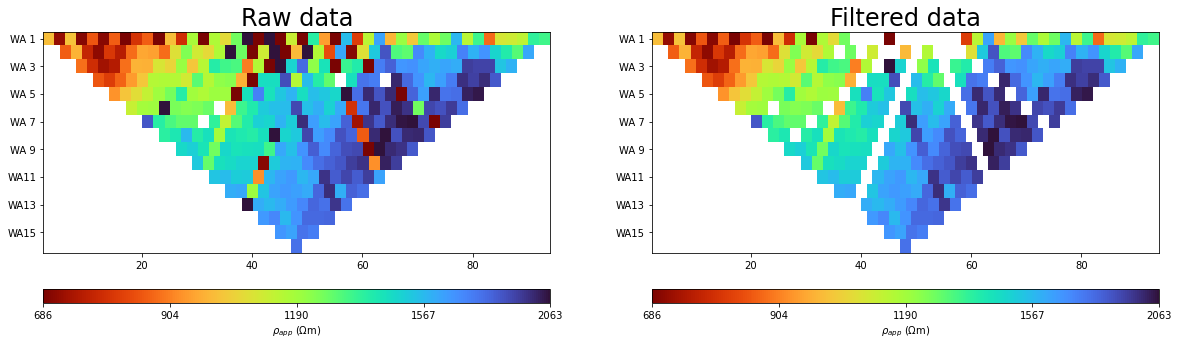

In [9]:
# put everything back into the pygimli data container

data_filt = pg.DataContainerERT()

# sensors are the same

for i in range(0,len(data_raw.sensors())):
    data_filt.createSensor(np.array(data_raw.sensors()[i])) # 2D, no topography

# add filtered quadripoles and data 

cols = df_filt.columns
for i in range(len(cols)):
    if max(df_elec_filt[cols[i]]) > 0:
        data_filt[cols[i]] = np.array(df_elec_filt[cols[i]])

# plot filtered data

fig, ax = plt.subplots(1,2,figsize=[20,5])

mgr = ert.ERTManager(data_checked)
mgr.showData(
    data_checked, 
    vals=data_checked['rhoa'],
    ax=ax[0],
    label=r'$\rho_{app}$ ($\Omega$m)',
    cMap='turbo_r',
    cMin=np.sort(data_filt['rhoa'])[int(len(data_filt['rhoa'])/100)], # this part trims the color scale to make things easier to see
    cMax=np.sort(data_filt['rhoa'])[-int(len(data_filt['rhoa'])/100)],
    logScale=True
);

ax[0].set_title('Raw data',fontsize=24);

mgr = ert.ERTManager(data_filt)
mgr.showData(
    data_filt, 
    vals=data_filt['rhoa'],
    ax=ax[1],
    label=r'$\rho_{app}$ ($\Omega$m)',
    cMap='turbo_r',
    cMin=np.sort(data_filt['rhoa'])[int(len(data_filt['rhoa'])/100)], # this part trims the color scale to make things easier to see
    cMax=np.sort(data_filt['rhoa'])[-int(len(data_filt['rhoa'])/100)],
    logScale=True);
ax[1].set_title('Filtered data',fontsize=24);

print('data points removed by technical filter = %.0f'%n_tf)
print('data points removed by moving median filter = %.0f'%n_mmf)
print('number of bad electrodes = %.0f'%n_ef)
print('data points removed by bad electrode filter = %.0f'%len(np.where(I_ef)[0]))
print('%.0f data points removed in total (%.1f%% of the data)'%(data_checked.size()-data_filt.size(), float((data_checked.size()-data_filt.size())/data_checked.size()*100)))


if (data_checked.size()-data_filt.size())/data_checked.size()*100>30:
    print('WARNING: too many data points filtered.')


## create error model

In [10]:
# TODO - set a minimum amount of repeated/reciprocal data that we would need to make an error model

# if there are reciprocal/repeated data, use those to make an error model

if len (r_all)>0:
    
    I = np.where(df_filt['rep/recip']==1)
    x = abs(df_filt['r'].iloc[I])
    y = abs(df_filt['err'].iloc[I])*abs(df_filt['r'].iloc[I])/100 # absolute error
    
    nbins = 20
    ndata = len(I[0])
    npoints = math.ceil(ndata/nbins)

    df_filt = df_filt.sort_values(by=['r'],key=abs)
    xbin = []
    ybin = []
    for i in range(nbins):
        xbin.append(np.mean(x[i*npoints:(i+1)*npoints]))
        ybin.append(np.std(y[i*npoints:(i+1)*npoints]))

    p = np.polyfit(xbin,ybin, 1)
        
    if p[1]<0: # if absolute error is negative, just assign some small value
        p[1]=1e-3
    p[0] = p[0] + 0.02 # increase relative error by 2% to account for other sources of error
    
    print('error model: err = %.4f*|R|+%.4f'%(p[0],p[1]))

    # automated (from error model)
    data_filt['err'] = ert.estimateError(
    data_filt, 
    absoluteError=p[1], 
    relativeError=p[0] # % noise
    ) 
    
# if no repeated/reciprocal data, just assume a 4% error model

else:
    
    data_filt['err'] = ert.estimateError(
    data_filt, 
    absoluteError=0.001, 
    relativeError=0.04 # % noise
    )
    
    

## invert the data

In [11]:

# set whether lambda is being optimized by L-curve
mgr = ert.ERTManager(data_filt)

mgr.inv.inv.setOptimizeLambda(True)

# use blocky model constraint

mgr.inv.inv.setBlockyModel(True)

# run inversion

mod = mgr.invert(
    data_filt,
    mesh=None,
    verbose=False, 
)

# getting lambda, chi2, rms error

lam = mgr.inv.inv.getLambda()
chi2 = mgr.inv.inv.getChi2()
rms = np.sqrt(np.mean(((data_filt['rhoa']-mgr.inv.response)/data_filt['rhoa'])**2))*100

27/06/22 - 14:41:28 - pyGIMLi - INFO - Found 2 regions.
27/06/22 - 14:41:28 - pyGIMLi - INFO - Region with smallest marker (1) set to background
27/06/22 - 14:41:28 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
27/06/22 - 14:41:28 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
27/06/22 - 14:41:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
27/06/22 - 14:41:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
27/06/22 - 14:41:28 - pyGIMLi - INFO - Use median(data values)=1512.5681304210539
27/06/22 - 14:41:28 - pyGIMLi - INFO - Created startmodel from forward operator: 702 [1512.5681304210539,...,1512.5681304210539]


## plot the results

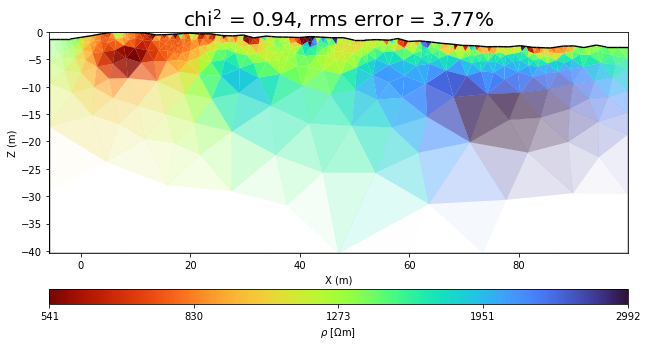

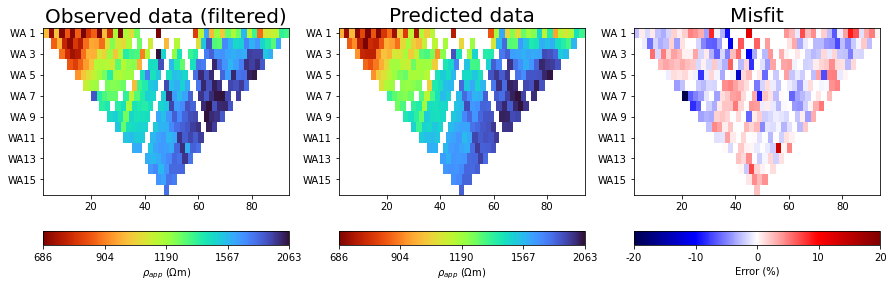

In [12]:

fig, ax = plt.subplots(1,1,figsize=[15,5])

ax, cBar = mgr.showResult(
   mod,
    ax=ax,
    cMap='turbo_r',
    coverage=mgr.coverage(),
    cMin=np.sort(mgr.paraModel())[int(len(mgr.paraModel())/100)], # this part trims the color scale to make things easier to see
    cMax=np.sort(mgr.paraModel())[-int(len(mgr.paraModel())/100)],

);

cBar.set_label(r'$\rho$ [$\Omega$m]')
ax.set_xlabel('X (m)')
ax.set_ylabel('Z (m)')
ax.set_title(r'chi$^2$ = %.2f, rms error = %.2f%%'%(chi2,rms),fontsize=20);

fig, ax = plt.subplots(1,3,figsize=[15,4])

mgr.showData(
    vals=data_filt['rhoa'],
    ax=ax[0],
    label=r'$\rho_{app}$ ($\Omega$m)',
    cMap='turbo_r',
    cMin=np.sort(data_filt['rhoa'])[int(len(data_filt['rhoa'])/100)],
    cMax=np.sort(data_filt['rhoa'])[-int(len(data_filt['rhoa'])/100)],
    logScale=True
);

mgr.showData(
    vals=mgr.inv.response,
    ax=ax[1],
    label=r'$\rho_{app}$ ($\Omega$m)',
    cMap='turbo_r',
    cMin=np.sort(data_filt['rhoa'])[int(len(data_filt['rhoa'])/100)],
    cMax=np.sort(data_filt['rhoa'])[-int(len(data_filt['rhoa'])/100)],
    logScale=True
);

mgr.showData(
    vals=((mgr.inv.response-data_filt['rhoa'])/data_filt['rhoa'])*100,
    ax=ax[2],
    label='Error (%)',
    cMap='seismic',
    cMin=-20,
    cMax=20
);

ax[0].set_title('Observed data (filtered)',fontsize=20)
ax[1].set_title('Predicted data',fontsize=20)
ax[2].set_title('Misfit',fontsize=20);

